In [1]:
# Tensorflow 2.3でメモリを指定及び節約して使うためのおまじない。
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[4], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[4], True)

import numpy as np
import random

np.random.seed(219)
random.seed(219)
tf.random.set_seed(219)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
SIZE = 128
DEPTH = 4

In [4]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def conv_block(inputs, kernel_size=(3,3), n_channels=32):
    
    # Convを二回行う
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(x)
    x = layers.Activation('relu')(x)

    return x

def upconv_block(inputs, n_channels=32):
    
    # Upsamplingでサイズを倍にした後、2x2 Convでチャネル数を変更。TransposeConvを使うのでも良い
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Conv2D(n_channels, (2,2), padding='same')(x)

    return x

In [5]:
def build_unet(size=(256,256,1), depth=4, n_classes=1):

    channels = [64 * 2**i for i in range(depth+1)]

    x_in = layers.Input(size)
    x = x_in

    downsampling_layers = []

    for i, c in enumerate(channels[:-1]):
        x_unpool = conv_block(inputs=x, n_channels=c)
        if i == (depth-1):
            x_unpool = layers.Dropout(0.5)(x_unpool)
        downsampling_layers.append(x_unpool)
        x = layers.MaxPooling2D((2,2))(x_unpool)

    x = conv_block(inputs=x, n_channels=channels[-1])
    x = layers.Dropout(0.5)(x)

    channels = channels[:-1][::-1]
    downsampling_layers = downsampling_layers[::-1]

    for i, c in enumerate(channels):
        x = upconv_block(inputs=x, n_channels=c)
        x = layers.Concatenate()([x, downsampling_layers[i]])
        x = conv_block(inputs=x, n_channels=c)

    x = layers.Conv2D(n_classes, (1,1), padding='same', activation='sigmoid')(x)

    return Model(inputs=x_in, outputs=x)

In [6]:
model = build_unet(size=(SIZE,SIZE,1), depth=DEPTH, n_classes=3)

In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

In [8]:
X_gray_dir = "/workdir/taki_lab/segmentation/flowerdataset/gray_train/"
Y_color_dir = "/workdir/taki_lab/segmentation/flowerdataset/color_train/"

In [9]:
def preprocessing_function(x):
    return x / 255.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 乱数のシード
rand_seed = 219 

image_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 rotation_range = 0.2,
                 shear_range = 0.05,
                 zoom_range = 0.05,
                 preprocessing_function = preprocessing_function
                 )
mask_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 rotation_range = 0.2,
                 shear_range = 0.05,
                 zoom_range = 0.05,
                 preprocessing_function = preprocessing_function
                 )

image_generator =image_datagen.flow_from_directory(X_gray_dir,
                                                   class_mode=None, # 分類じゃないので、カテゴリに関するyを使わない
                                                   seed=rand_seed, 
                                                   target_size=(SIZE, SIZE),
                                                   batch_size=32,
                                                   color_mode='grayscale') # 白黒なので1-channelにしておく

mask_generator = mask_datagen.flow_from_directory(Y_color_dir,
                                                  class_mode=None, 
                                                  seed=rand_seed, # 上と同じ乱数シードにしておくのがミソ。これで常にX線写真に対応するマスク画像を渡してくれる
                                                  target_size=(SIZE, SIZE), 
                                                  batch_size=32,
                                                  color_mode='rgb')

train_generator = zip(image_generator, mask_generator) # zipで二つのイテレータをまとめる

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

history = model.fit(train_generator,
                    steps_per_epoch=1000//32,
                    epochs=100,
                    verbose=2,
                    use_multiprocessing=True,
                    workers=20
                   )

Epoch 1/100
31/31 - 8s - loss: 0.6589
Epoch 2/100
31/31 - 8s - loss: 0.5719
Epoch 3/100
31/31 - 8s - loss: 0.5546
Epoch 4/100
31/31 - 9s - loss: 0.5387
Epoch 5/100
31/31 - 8s - loss: 0.5233
Epoch 6/100
31/31 - 8s - loss: 0.5332
Epoch 7/100
31/31 - 9s - loss: 0.5477
Epoch 8/100
31/31 - 8s - loss: 0.5270
Epoch 9/100
31/31 - 9s - loss: 0.5424
Epoch 10/100
31/31 - 8s - loss: 0.5349
Epoch 11/100
31/31 - 9s - loss: 0.5367
Epoch 12/100
31/31 - 9s - loss: 0.5340
Epoch 13/100
31/31 - 8s - loss: 0.5166
Epoch 14/100
31/31 - 9s - loss: 0.5088
Epoch 15/100
31/31 - 8s - loss: 0.5050
Epoch 16/100
31/31 - 8s - loss: 0.5339
Epoch 17/100
31/31 - 8s - loss: 0.5292
Epoch 18/100
31/31 - 8s - loss: 0.5185
Epoch 19/100
31/31 - 8s - loss: 0.5142
Epoch 20/100
31/31 - 60s - loss: 0.5032
Epoch 21/100
31/31 - 5s - loss: 0.5292
Epoch 22/100
31/31 - 8s - loss: 0.5391
Epoch 23/100
31/31 - 8s - loss: 0.5040
Epoch 24/100
31/31 - 8s - loss: 0.5182
Epoch 25/100
31/31 - 8s - loss: 0.5368
Epoch 26/100
31/31 - 8s - loss: 0

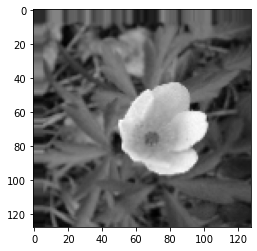

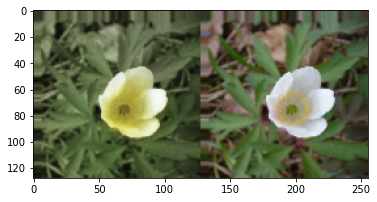

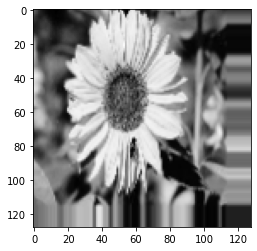

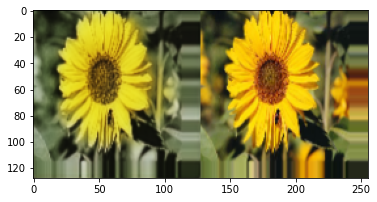

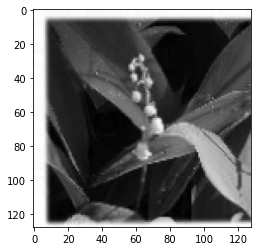

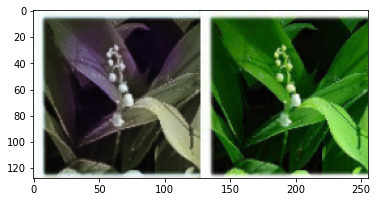

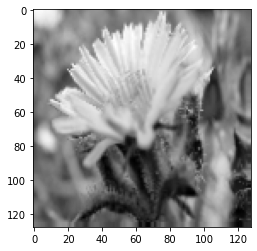

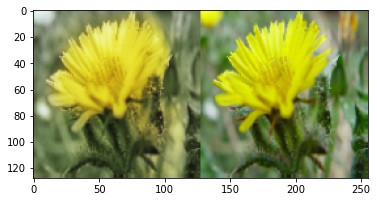

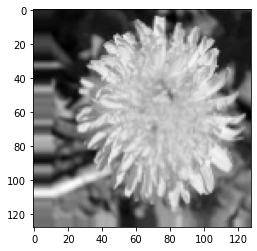

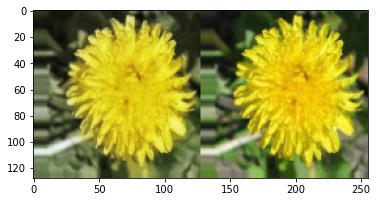

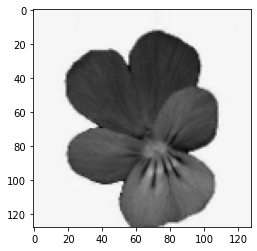

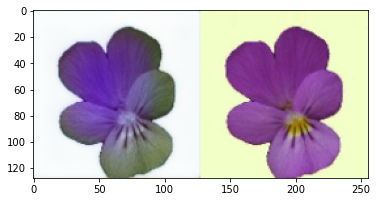

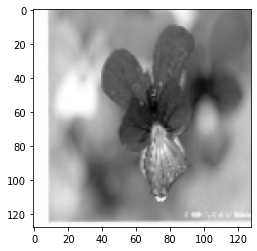

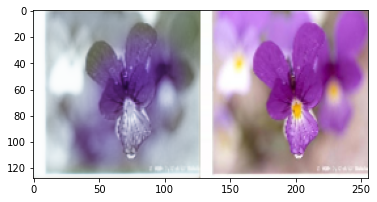

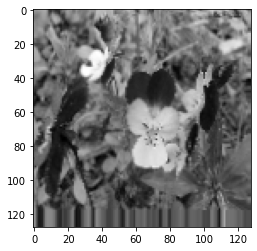

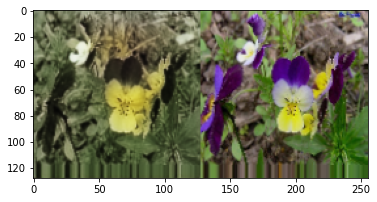

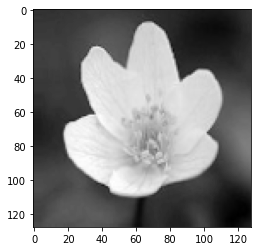

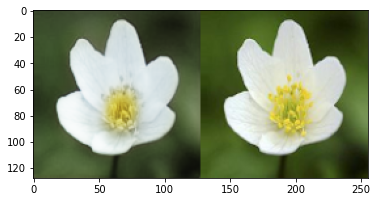

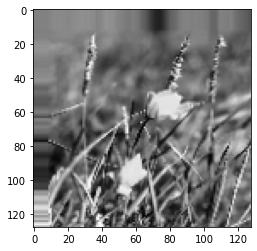

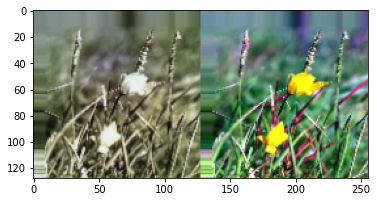

In [14]:
i = 0
for xs, ys in train_generator:
    i += 1 
    preds = model.predict(xs)
    plt.imshow(xs[0,:,:,0], cmap="gray")
    plt.show()
    img2 = np.concatenate([preds[0,:,:,:], ys[0,:,:,:]], axis=1)
    plt.imshow(img2)
    plt.show()
    if i == 10:
        break
    